In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
import sys
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from brian2 import *

In [4]:
sys.path.append("../lib") # add code library to paths

# add lib to path 
from model_beta import Model



In [5]:
# TODO: turn this into  script

In [6]:
netname = 'recurrent_nn'
model = Model(netname)  # initiate the model


../output/recurrent_nn


In [7]:
params = {
'sig_c' : 0.05  ,    # bipolar receptive fied size ~ 1/5 of the actual size [mm]
'tau1' : 0.04   ,    # excitation time constant of the temporal filter [s]
'tau2' : 0.0876 ,    # rebound time constant [s]
'bifw' : 0.     ,    # relative weight of rebound/excitation [1]

'scale_mV' : 20.,     # UPDATED 

'tauA' : 0.15   ,     # time constant of amacrine cells [s]
'tauB' : 0.08   ,     # time constant of bipolar cells [s]
'tauG' : 0.01   ,     # time contant of ganglion cells [s]

'wAB' : 10.     ,     # synaptic weight from bipolar to amacrine [Hz]
'wBA' : -10.    ,     # synaptic weight from amacrine to bipolar [Hz]
'wGB' : 4.0     ,     # synaptic weight from bipolar to gangion  [Hz].   #UPDATED
'wGA' : 0.      ,     # synaptic weight from amacrine  to gangion  [Hz]

'slope' : 5     ,     # slope for ganglion cell recritifation [Hz/mV].   #UPDATED
'threshold' : 0 ,     # threshold for ganglion cell recritifation [Hz/mV]
'sig_pool' : 0.065 ,  # sigma for gaussian pooling in ganlion gells [mm]


'spacing' : 0.005  ,  # spacing of cells on the lattice [mm]
'dt' : 0.001      ,   # integration time step [s]
'N' : 512          ,  # number of neurons in each layer [1]


# idx = int(N/2)
# b =  0.160         # half bar width [mm]
# speed =  0.8       # speed [mm/s]  
}


In [8]:

# create connectivity matrix TODO write a class for this !!!

C = np.zeros((params['N'],params['N']))
ii = np.arange(0,params['N']-1,1).astype(int)  # list of source cells for rightward connections
ji = ii + 1                          # target cells of rightward connections


C[ii,ji] = 1

ii = np.arange(1,params['N'],1).astype(int)    # list of source cells for leftward connections
ji = ii - 1                         # target cells of leftward connections

C[ii,ji] = 1


In [9]:

model.set_params(params)
model.set_connectivity(C)


# simulate response to global step full contrast

In [10]:

# function to make bar stimulus
def bar(t, x, b, v):

    if x >=-b+v*t and x <=b+v*t :
        return 1
    else:
        return 0


speed = 0.8
b = 0.16
L = params['N']*params['spacing']
dt = params['dt']
dur = L/speed                 # duration of the simulation [s]
tps = int(dur/params['dt'])             # number of time-points in the simulation [1]

# # #enfroce tps to pe power of 2 
# import math
# # pow = np.floor(math.log2(tps))+1
# # tps = int(2**pow)
# # print(pow,tps)
# pow = np.floor(math.log2(tps))
# tps = int(2**pow)
# dt = dur/tps


time = np.arange(0,tps)*dt    # time array for the simulation 1xtps, in [s]


# make bar stimulus
barstim = np.zeros((params['N'],tps))

for n in range(params['N']):
    for ti in range(tps):
        xi = n*params['spacing']
        barstim[n,ti] = bar(ti*dt,xi,b,speed)


S = barstim

print(S.shape,L)

(512, 3199) 2.56


In [11]:
model.set_stimulus(S,f'bar_{speed}')
model.simulate()

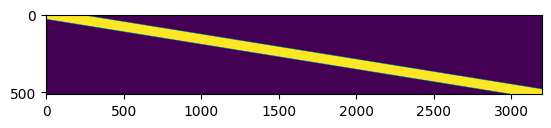

In [12]:
plt.imshow(S)

In [13]:
# loop over speeds 
speeds = np.round(np.arange(0.1,1.1,0.1),1)

for s in speeds: 
    
    dur = L/s                 # duration of the simulation [s]
    tps = int(dur/params['dt'])             # number of time-points in the simulation [1]
    print(tps)
    # #enfroce tps to pe power of 2 
    # import math
    # # pow = np.floor(math.log2(tps))+1
    # # tps = int(2**pow)
    # # print(pow,tps)
    # pow = np.floor(math.log2(tps))
    # tps = int(2**pow)
    # dt = dur/tps


    time = np.arange(0,tps)*dt    # time array for the simulation 1xtps, in [s]


    # make bar stimulus
    barstim = np.zeros((params['N'],tps))

    for n in range(params['N']):
        for ti in range(tps):
            xi = n*params['spacing']
            barstim[n,ti] = bar(ti*dt,xi,b,s)

    S = barstim
    print(S.shape)
    stimname = f'bar_{s}'
    model.set_stimulus(S,stimname)
    model.simulate()

25599
(512, 25599)
12799
(512, 12799)


KeyboardInterrupt: 

(512, 12799)

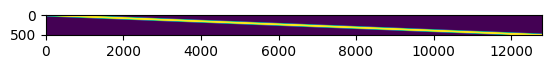

In [14]:
plt.imshow(barstim)
barstim.shape

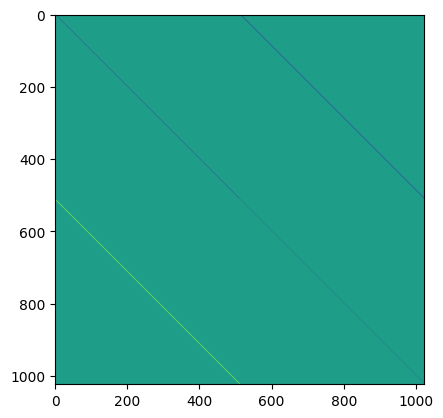

In [15]:
N = 512
spacing = 0.005
tauB = params['tauB']
tauA = params['tauA']
wBA = params['wBA']
wAB = params['wAB']

A = np.zeros((N*2,N*2))


template = np.zeros((N,N))


BB = template.copy()
AA = template.copy()
BA = template.copy()
AB = template.copy()


np.fill_diagonal(BB,-1/tauB)
np.fill_diagonal(AA,-1/tauA)



ii = np.arange(0,N-1,1).astype(int)  # list of source cells for rightward connections
ji = ii + 1                          # target cells of rightward connections

BA[ii,ji] = wBA

ii = np.arange(1,N,1).astype(int)    # list of source cells for leftward connections
ji = ii - 1                         # target cells of leftward connections

BA[ii,ji] = wBA


AB = template.copy()

ii = np.arange(0,N-1,1).astype(int)  # list of source cells for rightward connections
ji = ii + 1                          # target cells of rightward connections


AB[ii,ji] = wAB


ii = np.arange(1,N,1).astype(int)    # list of source cells for leftward connections
ji = ii - 1                         # target cells of leftward connections

AB[ii,ji] = wAB

BB.shape
BA.shape
A = np.vstack((np.hstack((BB,BA)), np.hstack((AB,AA))))
plt.imshow(A)


In [16]:
wBA,wAB

(-10.0, 10.0)

[[-12.5          0.           0.         ...   0.           0.
    0.        ]
 [  0.         -12.5          0.         ...   0.           0.
    0.        ]
 [  0.           0.         -12.5        ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  -6.66666667   0.
    0.        ]
 [  0.           0.           0.         ...   0.          -6.66666667
    0.        ]
 [  0.           0.           0.         ...   0.           0.
   -6.66666667]]


WARNING    /.pyenv/versions/3.11.5/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
 [py.warnings]


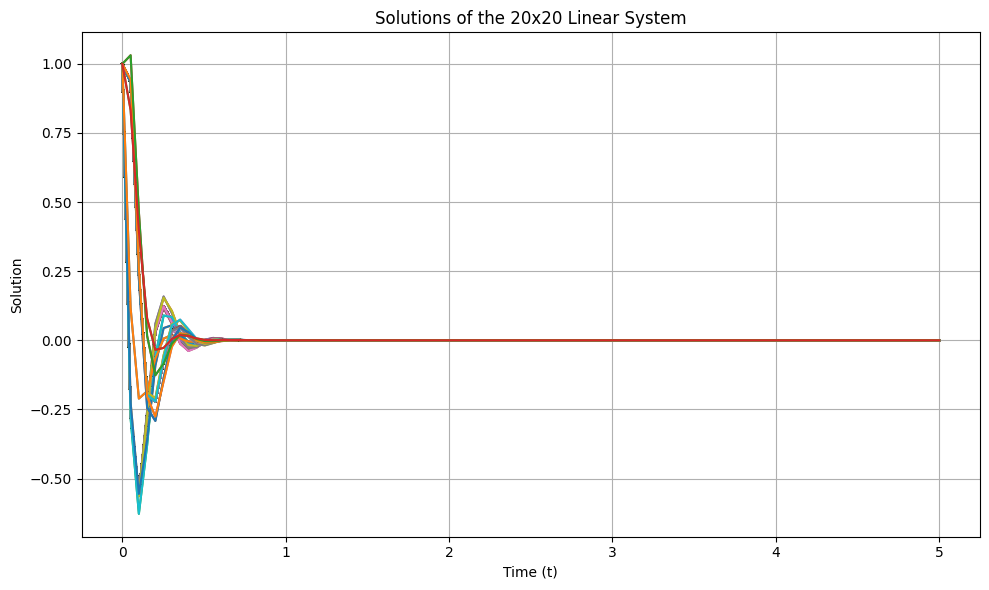

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define the coefficient matrix A (example: 20x20)
# np.random.seed(42)  # For reproducibility
# n = 2  # Size of the system
# A = np.random.rand(n, n)  # Random 20x20 matrix
n = N*2
print(A)
# Define initial condition (size n)
X0 = np.ones(n)

# Step 1: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(A)

# Eigenvector matrix (columns are eigenvectors)
V = eigenvectors

# Step 2: Solve for constants c1, c2, ..., cn
# X0 = V @ C --> C = V^-1 @ X0
C = np.linalg.solve(V, X0)  # Solving for constants C = [c1, c2, ..., cn]

# Step 3: Define the solution as a function of time
def X(t):
    # Compute the solution as a sum of eigenvector components
    terms = [C[i] * V[:, i] * np.exp(eigenvalues[i] * t) for i in range(n)]
    return np.sum(terms, axis=0)  # Sum up all contributions

# Time range for the solution
t_values = np.linspace(0, 5, 100)  # t in [0, 5]
solutions = np.array([X(t) for t in t_values])

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.plot(t_values, solutions[:, i], label=f"x{i+1}(t)")

plt.xlabel("Time (t)")
plt.ylabel("Solution")
plt.title("Solutions of the 20x20 Linear System")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.grid()
plt.tight_layout()
plt.show()


In [18]:
V.shape,X0.shape

((1024, 1024), (1024,))

WARNING    The object 'neurongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/gpfs01/berens/user/sebert/Repositories/motion_anticipation_network/Brian/notebooks/../lib/model_beta.py', line 194, in simulate
    bc = NeuronGroup(self.N, eqs_bc,  method = 'rk4') [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/gpfs01/berens/user/sebert/Repositories/motion_anticipation_network/Brian/notebooks/../lib/model_beta.py', line 195, in simulate
    ac = NeuronGroup(self.N, eqs_ac,  method = 'rk4') [brian2

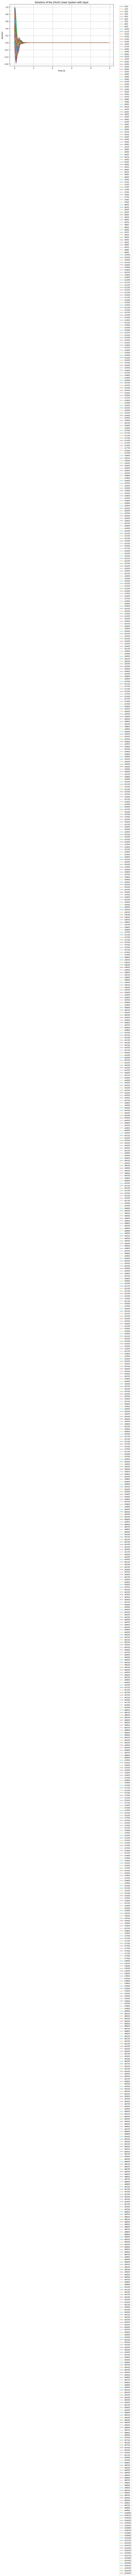

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm


# Define initial condition (size n)
X0 = np.random.rand(n)

# Define the input vector function B(t)
def B(t):

    v = 0.8
    b = 0.16

    B_out = np.zeros(N*2)

    for c in range(N):

        x = n * spacing  

        if x >=-b+v*t and x <=b+v*t :
            
            B_out[c] = 1
        else:
            B_out[c] = 0

    return B_out
        

    # Example: Sinusoidal input affecting all states
    # return np.sin(2 * np.pi * t) * np.ones(n)

# Time range for the solution
t_values = np.linspace(0, 5, 100)[:-1]  # t in [0, 5]


# Step 1: Compute eigenvalues and eigenvectors (for homogeneous solution)
eigenvalues, eigenvectors = np.linalg.eig(A)

# Eigenvector matrix (columns are eigenvectors)
V = eigenvectors

# Solve for constants c1, c2, ..., cn using the initial condition
C = np.linalg.solve(V, X0)

# Step 2: Define the homogeneous solution
def X_h(t):
    terms = [C[i] * V[:, i] * np.exp(eigenvalues[i] * t) for i in range(n)]
    return np.sum(terms, axis=0)

# Step 3: Compute the particular solution using numerical integration
def X_p(t_values):
    dt = t_values[1] - t_values[0]  # Time step
    X_p_sol = np.zeros((len(t_values), n))  # Initialize solution array
    
    for i, t in enumerate(t_values):
        integral = np.zeros(n)  # Initialize integral at time t
        for tau in t_values[:i+1]:
            exp_At_tau = expm(A * (t - tau))  # Compute e^{A(t - τ)}
            integral += exp_At_tau @ B(tau) * dt
        X_p_sol[i, :] = integral
    return X_p_sol


# Compute homogeneous and particular solutions
X_h_values = np.array([X_h(t) for t in t_values])
X_p_values = X_p(t_values)

# Total solution
solutions = X_h_values + X_p_values

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.plot(t_values, solutions[:, i], label=f"x{i+1}(t)")

plt.xlabel("Time (t)")
plt.ylabel("Solution")
plt.title("Solutions of the 20x20 Linear System with Input")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid()
plt.tight_layout()
plt.show()